In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

- SETTING UP THE PLOTS CONFIGURATION

In [10]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_14319/2020220598.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [29]:
data = pd.read_csv('data/NFLX.csv', parse_dates=['Date'])
data = data.set_index("Date").to_period('D')
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000


In [18]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

ff = fourier_features(index=y.index, freq=365, order=3)
ff

,sin_365_1,cos_365_1,sin_365_2,cos_365_2,sin_365_3,cos_365_3
Date,,,,,,
2018-02-05,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2018-02-06,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667
2018-02-07,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671
2018-02-08,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023
2018-02-09,0.068802,0.997630,0.137279,0.990532,0.205105,0.978740
...,...,...,...,...,...,...
2022-01-31,-0.999991,0.004304,-0.008608,-0.999963,0.999917,-0.012911
2022-02-01,-0.999768,0.021516,-0.043023,-0.999074,0.997917,-0.064510
2022-02-02,-0.999250,0.038722,-0.077386,-0.997001,0.993257,-0.115936


In [19]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [20]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

### WORKING WITH DATA

In [38]:
X = data.drop(columns=['High','Low','Close','Adj Close','Volume'])
X['Day'] = X.index.dayofweek
X['Week'] = X.index.week
X['Dayofyear'] = X.index.day_of_year
X['Year'] = X.index.year
X

,Open,Day,Week,Dayofyear,Year
Date,,,,,
2018-02-05,262.000000,0,6,36,2018
2018-02-06,247.699997,1,6,37,2018
2018-02-07,266.579987,2,6,38,2018
2018-02-08,267.079987,3,6,39,2018
2018-02-09,253.850006,4,6,40,2018
...,...,...,...,...,...
2022-01-31,401.970001,0,5,31,2022
2022-02-01,432.959991,1,5,32,2022
2022-02-02,448.250000,2,5,33,2022


/tmp/ipykernel_14319/1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/tmp/ipykernel_14319/1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


<AxesSubplot: title={'center': 'Seasonal Plot (Year/Dayofyear)'}, xlabel='Dayofyear', ylabel='Open'>

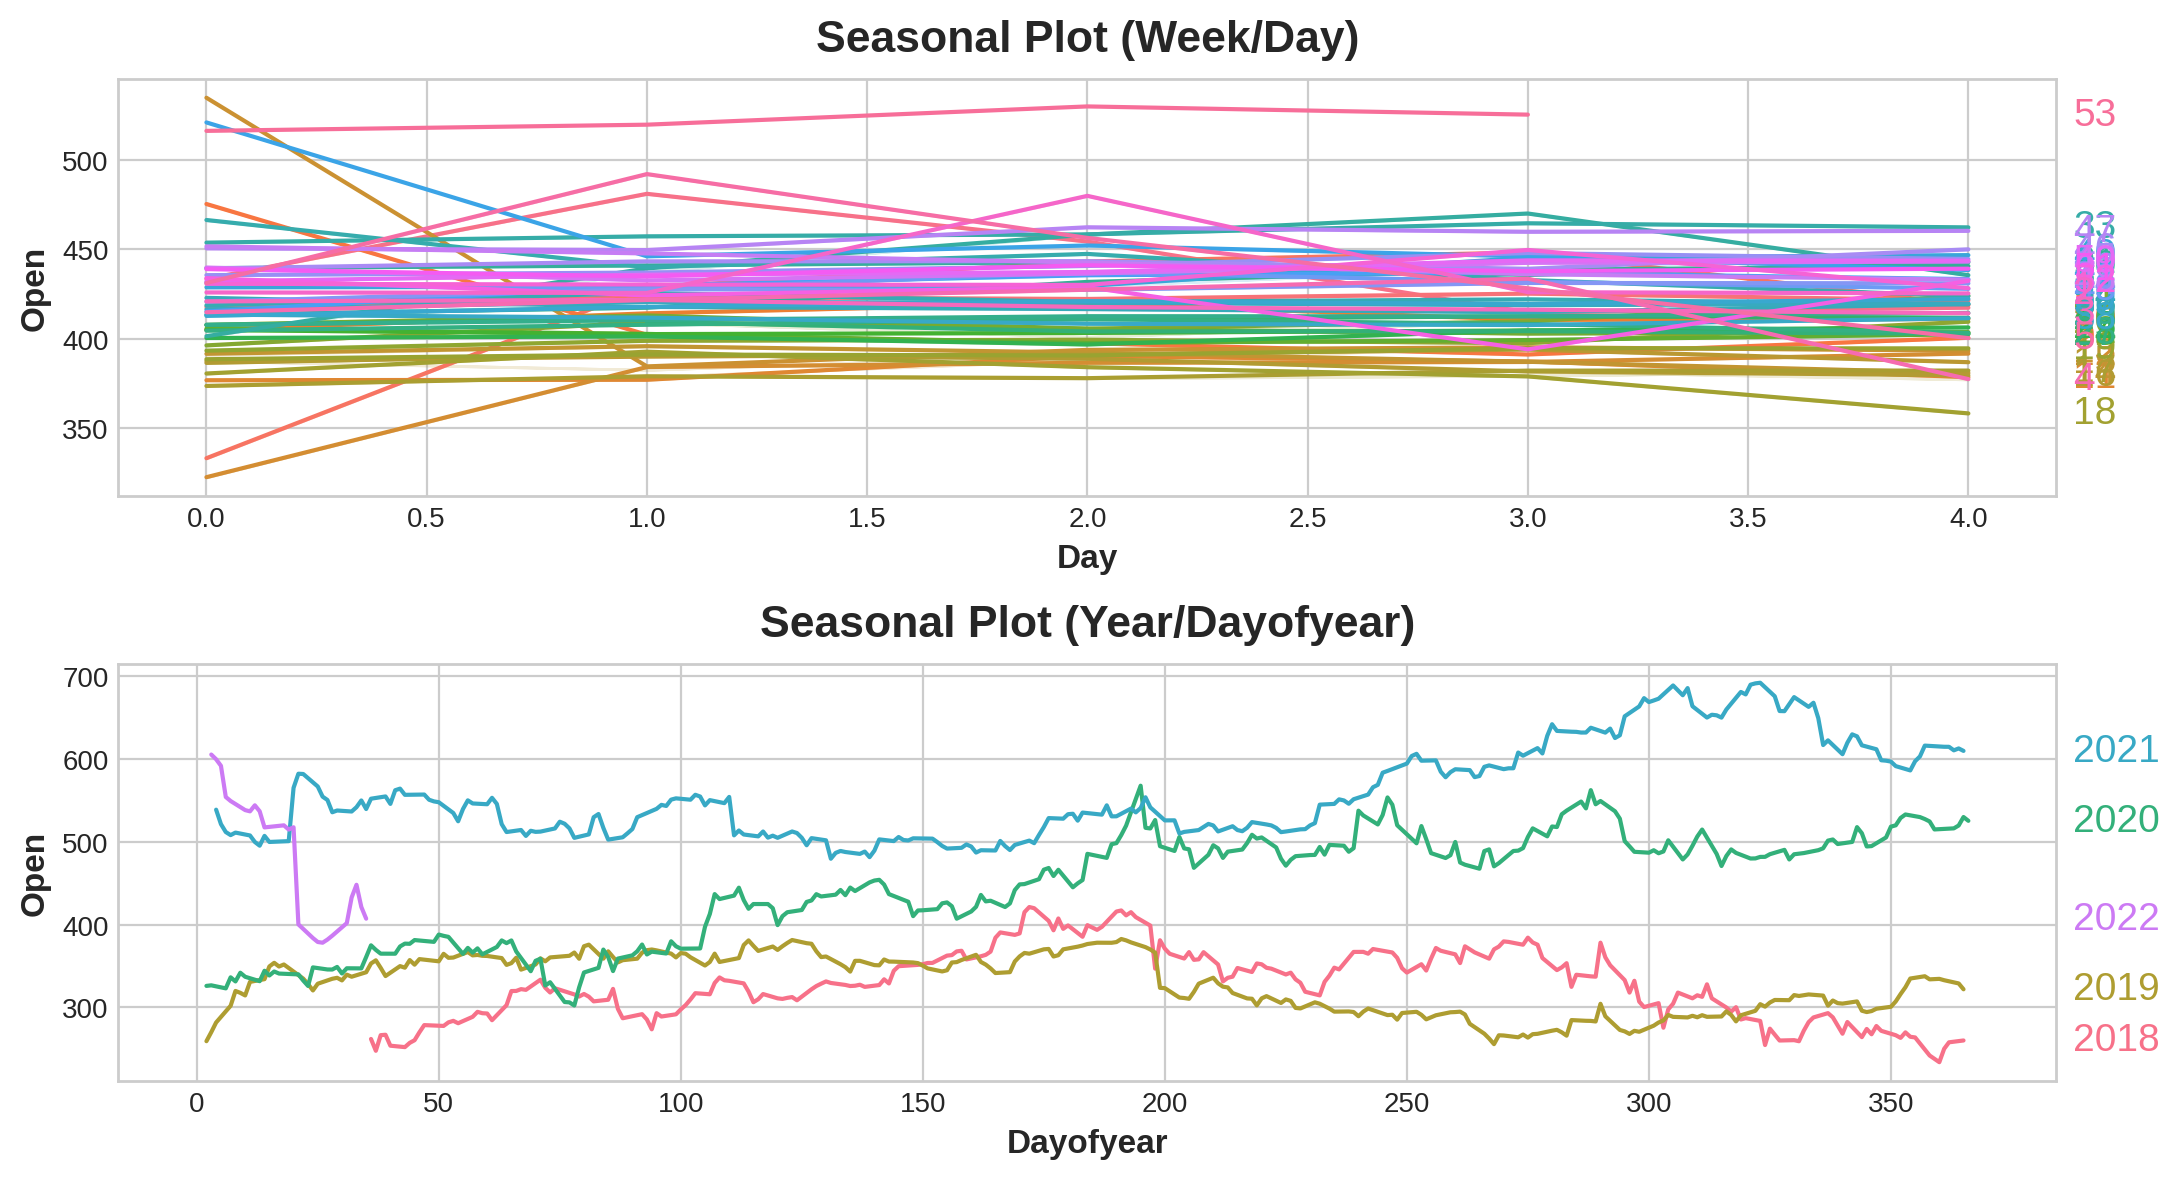

In [40]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="Open", period="Week", freq="Day", ax=ax0)
seasonal_plot(X, y="Open", period="Year", freq="Dayofyear", ax=ax1)